## Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import time
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
import os
from calendar import monthrange
!pip install GeoPandas
import geopandas as gpd
from pandas.plotting import scatter_matrix
import datetime as dt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

     |████████████████████████████████| 972kB 4.0MB/s 
     |████████████████████████████████| 10.9MB 10.5MB/s 
     |████████████████████████████████| 14.8MB 209kB/s 


In [3]:
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
df = pd.read_csv(file_path_merge_May_Sep_5km)
df

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),electricity,wind_speed
0,2019-01-01 01:00:00,18.565386,3097,20.916341,16101,26.393900,31739,74.0,23.955315,57.0,1016.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01728,0.048043,0.0,17.280000,7.992000,22.493519,29.024128,14.689588,8.225035,21.986542,139.0,1544.0,3171.0,5880.0,25.28,16.51,7.54,23.15,28.360016,0.257,12.849623,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573,0.087,4.465
1,2019-01-01 02:00:00,22.872611,2355,25.613285,11140,30.391756,25715,80.0,22.555315,62.0,1015.8,0.0,0.9,0.000000,0.0,0.0,0.0,0.01296,0.036601,0.0,22.319998,7.506620,20.150354,27.257967,16.641972,6.924738,22.725668,137.0,1540.0,3166.0,5873.0,24.69,16.68,7.27,22.03,27.529999,0.257,10.435104,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486,0.076,4.291
2,2019-01-01 03:00:00,23.259295,2098,26.335067,9804,31.385424,22845,65.0,21.445314,67.0,1015.7,0.0,6.9,0.000000,0.0,0.0,0.0,0.01152,0.027955,0.0,23.400000,7.246862,18.514643,25.364037,18.626305,6.193674,23.199759,136.0,1538.0,3164.0,5869.0,24.10,16.88,7.08,21.08,26.730011,0.257,8.469172,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248,0.071,4.216
3,2019-01-01 04:00:00,25.040327,1711,28.187279,8207,32.356202,19065,65.0,20.525314,71.0,1015.6,0.0,6.3,0.000000,0.0,0.0,0.0,0.01008,0.022798,0.0,21.960000,7.315093,19.242327,24.575110,20.972897,5.860375,23.424908,134.0,1535.0,3162.0,5866.0,23.34,17.03,6.90,20.26,25.920013,0.257,7.033592,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572,0.041,3.639
4,2019-01-01 05:00:00,26.249147,1465,29.381196,7041,32.442185,17651,57.0,19.845314,74.0,1015.9,0.0,9.0,0.000000,0.0,0.0,0.0,0.01008,0.018804,0.0,21.960000,7.315093,19.137648,24.735432,22.473343,5.904439,23.933908,137.0,1537.0,3163.0,5867.0,22.42,17.10,6.75,19.61,25.179993,0.257,6.046389,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.609710,0.792624,-0.691905,0.721988,0.032,3.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8588,2019-12-31 19:00:00,18.119312,4593,18.314281,23409,23.467039,42065,68.0,30.415314,49.0,1012.4,0.0,10.0,2.412766,0.0,0.0,0.0,0.00144,0.038127,191.0,11.520000,4.861344,17.015474,

In [4]:
df

,timestamp,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),electricity,wind_speed
0,2019-01-01 01:00:00,18.565386,3097,20.916341,16101,26.393900,31739,74.0,23.955315,57.0,1016.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01728,0.048043,0.0,17.280000,7.992000,22.493519,29.024128,14.689588,8.225035,21.986542,139.0,1544.0,3171.0,5880.0,25.28,16.51,7.54,23.15,28.360016,0.257,12.849623,0.600000,8.000001e-01,0.768221,6.401844e-01,0.868243,0.496139,0.808736,0.588172,-0.919145,0.393919,-0.769561,0.638573,0.087,4.465
1,2019-01-01 02:00:00,22.872611,2355,25.613285,11140,30.391756,25715,80.0,22.555315,62.0,1015.8,0.0,0.9,0.000000,0.0,0.0,0.0,0.01296,0.036601,0.0,22.319998,7.506620,20.150354,27.257967,16.641972,6.924738,22.725668,137.0,1540.0,3166.0,5873.0,24.69,16.68,7.27,22.03,27.529999,0.257,10.435104,0.461353,8.872168e-01,0.661030,7.503591e-01,0.832050,0.554700,0.778754,0.627330,-0.883788,0.467888,-0.760374,0.649486,0.076,4.291
2,2019-01-01 03:00:00,23.259295,2098,26.335067,9804,31.385424,22845,65.0,21.445314,67.0,1015.7,0.0,6.9,0.000000,0.0,0.0,0.0,0.01152,0.027955,0.0,23.400000,7.246862,18.514643,25.364037,18.626305,6.193674,23.199759,136.0,1538.0,3164.0,5869.0,24.10,16.88,7.08,21.08,26.730011,0.257,8.469172,0.294086,9.557790e-01,0.447213,8.944273e-01,0.823213,0.567733,0.753773,0.657135,-0.813733,0.581239,-0.744835,0.667248,0.071,4.216
3,2019-01-01 04:00:00,25.040327,1711,28.187279,8207,32.356202,19065,65.0,20.525314,71.0,1015.6,0.0,6.3,0.000000,0.0,0.0,0.0,0.01008,0.022798,0.0,21.960000,7.315093,19.242327,24.575110,20.972897,5.860375,23.424908,134.0,1535.0,3162.0,5866.0,23.34,17.03,6.90,20.26,25.920013,0.257,7.033592,0.182089,9.832820e-01,0.299340,9.541465e-01,0.849640,0.527363,0.772425,0.635106,-0.675725,0.737154,-0.722308,0.691572,0.041,3.639
4,2019-01-01 05:00:00,26.249147,1465,29.381196,7041,32.442185,17651,57.0,19.845314,74.0,1015.9,0.0,9.0,0.000000,0.0,0.0,0.0,0.01008,0.018804,0.0,21.960000,7.315093,19.137648,24.735432,22.473343,5.904439,23.933908,137.0,1537.0,3163.0,5867.0,22.42,17.10,6.75,19.61,25.179993,0.257,6.046389,0.182089,9.832820e-01,0.282166,9.593656e-01,0.931457,0.363851,0.816968,0.576683,-0.609710,0.792624,-0.691905,0.721988,0.032,3.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8588,2019-12-31 19:00:00,18.119312,4593,18.314281,23409,23.467039,42065,68.0,30.415314,49.0,1012.4,0.0,10.0,2.412766,0.0,0.0,0.0,0.00144,0.038127,191.0,11.520000,4.861344,17.015474,

## Split data

In [5]:
# index_drop = np.arange(start= 52, stop= 263)
# for i in range(len(index_drop)):
#   df.drop(df.columns[51], axis = 1, inplace=True)
df.drop(columns={'timestamp'}, inplace=True)

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
test_df

,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),Bangkok Wind Direction [80 m](cos),Bangkok Wind Direction [900 mb](sin),Bangkok Wind Direction [900 mb](cos),Bangkok Wind Direction [850 mb](sin),Bangkok Wind Direction [850 mb](cos),Bangkok Wind Direction [700 mb](sin),Bangkok Wind Direction [700 mb](cos),Bangkok Wind Direction [500 mb](sin),Bangkok Wind Direction [500 mb](cos),electricity,wind_speed
7733,24.483095,1331,26.049514,6685,27.886469,15890,65.0,20.905313,69.0,1011.1,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.00432,0.026373,0.0,18.720000,7.506620,25.501621,32.241615,24.480000,23.803596,35.280000,97.0,1508.0,3141.0,5856.0,25.25,17.42,9.00,20.31,25.160004,0.220,7.696638,0.461353,8.872168e-01,0.663487,7.481878e-01,0.960250,0.279142,1.000000,1.745329e-07,0.998168,-6.049507e-02,1.000000,1.745329e-07,0.056,3.940
7734,26.704956,1715,26.647475,9605,28.741427,22659,68.0,20.265314,71.0,1011.4,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.00576,0.022616,0.0,16.919998,7.329631,23.065300,30.147717,26.640000,24.840000,34.567497,99.0,1510.0,3143.0,5857.0,24.67,17.54,8.94,19.73,24.570007,0.220,6.921623,0.327110,9.449862e-01,0.561883,8.272168e-01,0.979179,0.203001,1.000000,1.745329e-07,1.000000,1.745329e-07,0.999783,-2.082882e-02,0.038,3.578
7735,19.409992,2422,19.907440,12997,21.022628,29653,70.0,19.605314,73.0,1011.8,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.00432,0.018862,0.0,24.119999,7.108438,20.945070,29.627363,30.242140,25.919998,34.217045,102.0,1513.0,3146.0,5860.0,24.10,17.58,8.94,19.19,23.970001,0.220,6.186180,0.224860,9.743911e-01,0.481259,8.765786e-01,0.996376,0.085056,0.999929,-1.190374e-02,1.000000,1.745329e-07,0.999502,-3.156323e-02,0.026,3.278
7736,12.074992,2987,13.550236,14223,14.611843,34383,85.0,20.045315,72.0,1012.7,0.0,0.0,37.533333,25.81000,13.569255,12.240745,0.01440,0.024851,0.0,25.560000,7.007889,18.032370,30.978832,33.847656,27.002400,34.230300,110.0,1520.0,3153.0,5868.0,23.66,17.57,8.98,21.01,23.520020,0.220,6.592670,0.152057,9.883718e-01,0.439210,8.983845e-01,0.999392,-0.034863,0.999774,-2.127159e-02,0.999911,-1.333200e-02,0.999115,-4.206782e-02,0.038,3.579
7737,10.525802,3178,13.271651,15288,15.243079,37062,107.0,24.035315,58.0,1013.4,0.0,0.0,60.000000,214.48999,119.650390,94.839600,0.08928,0.148276,0.0,20.880001,8.172013,11.440979,33.962330,37.081750,28.460497,34.606842,115.0,1527.0,3160.0,5875.0,22.93,17.54,9.05,26.98,23.809998,0.220,12.611218,0.325991,9.453730e-01,0.409056,9.125094e-01,0.996398,-0.084800,0.999953,9.708241e-03,0.999280,-3.794719e-02,0.998646,-5.201281e-02,0.121,4.927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8588,18.119312,4593,18.314281,23409,23.467039,42065,68.0,30.415314,49.0,1012.4,0.0,10.0,2.412766,0.00000,0.000000,0.000000,0.00144,0.03

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [9]:
np.arange(24)[slice(0, 13)]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def plot(self, model=None, plot_col='num_cars_2km', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Make dataset

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Single step models

In [15]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['num_cars_2km'])
single_step_window.train

<MapDataset shapes: ((None, 1, 51), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [16]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 51)
Labels shape (batch, time, features): (64, 1, 1)


### Baseline

In [17]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [18]:
baseline = Baseline(label_index=column_indices['num_cars_2km'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

27/27 [==============================] - 0s 5ms/step - loss: 0.1533 - mean_absolute_error: 0.3110


In [19]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['num_cars_2km'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['num_cars_2km']

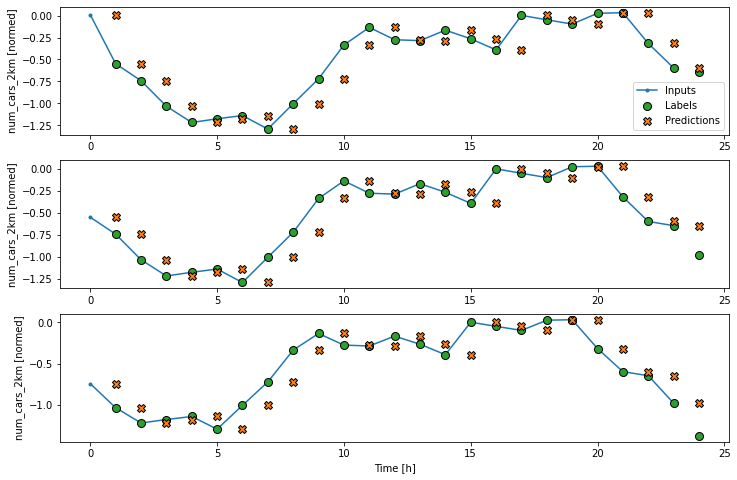

In [20]:
wide_window.plot(baseline)

### Linear model

In [21]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50)
])

In [22]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=500,
    decay_rate=0.9)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate= lr_schedule),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      # ,callbacks=[early_stopping])
  return history

In [23]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/30
94/94 [==============================] - 1s 9ms/step - loss: 1.2117 - mean_absolute_error: 0.8606 - val_loss: 1.2218 - val_mean_absolute_error: 0.8815
Epoch 2/30
94/94 [==============================] - 1s 7ms/step - loss: 0.5754 - mean_absolute_error: 0.5957 - val_loss: 0.7516 - val_mean_absolute_error: 0.6884
Epoch 3/30
94/94 [==============================] - 1s 7ms/step - loss: 0.3853 - mean_absolute_error: 0.4887 - val_loss: 0.5388 - val_mean_absolute_error: 0.5804
Epoch 4/30
94/94 [==============================] - 1s 7ms/step - loss: 0.2904 - mean_absolute_error: 0.4246 - val_loss: 0.4209 - val_mean_absolute_error: 0.5120
Epoch 5/30
94/94 [==============================] - 1s 7ms/step - loss: 0.2316 - mean_absolute_error: 0.3791 - val_loss: 0.3450 - val_mean_absolute_error: 0.4631
Epoch 6/30
94/94 [==============================] - 1s 7ms/step - loss: 0.1922 - mean_absolute_error: 0.3450 - val_loss: 0.2918 - val_mean_absolute_error: 0.4254
Epoch 7/30
94/94 [==========

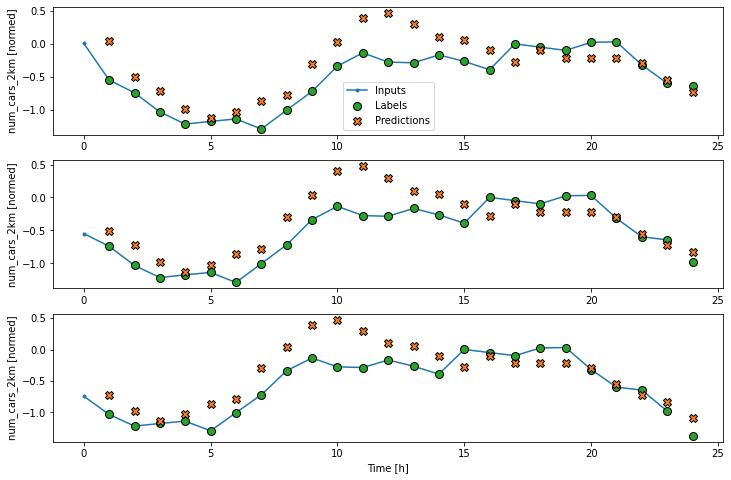

In [24]:
wide_window.plot(linear)

### Dense

In [25]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/30
94/94 [==============================] - 1s 13ms/step - loss: 0.2459 - mean_absolute_error: 0.3878 - val_loss: 0.1767 - val_mean_absolute_error: 0.3312
Epoch 2/30
94/94 [==============================] - 1s 11ms/step - loss: 0.1347 - mean_absolute_error: 0.2877 - val_loss: 0.1269 - val_mean_absolute_error: 0.2741
Epoch 3/30
94/94 [==============================] - 1s 11ms/step - loss: 0.1141 - mean_absolute_error: 0.2628 - val_loss: 0.1223 - val_mean_absolute_error: 0.2747
Epoch 4/30
94/94 [==============================] - 1s 11ms/step - loss: 0.1037 - mean_absolute_error: 0.2502 - val_loss: 0.1533 - val_mean_absolute_error: 0.3148
Epoch 5/30
94/94 [==============================] - 1s 10ms/step - loss: 0.0995 - mean_absolute_error: 0.2449 - val_loss: 0.1585 - val_mean_absolute_error: 0.3189
Epoch 6/30
94/94 [==============================] - 1s 11ms/step - loss: 0.1043 - mean_absolute_error: 0.2517 - val_loss: 0.1941 - val_mean_absolute_error: 0.3618
Epoch 7/30
94/94 [====

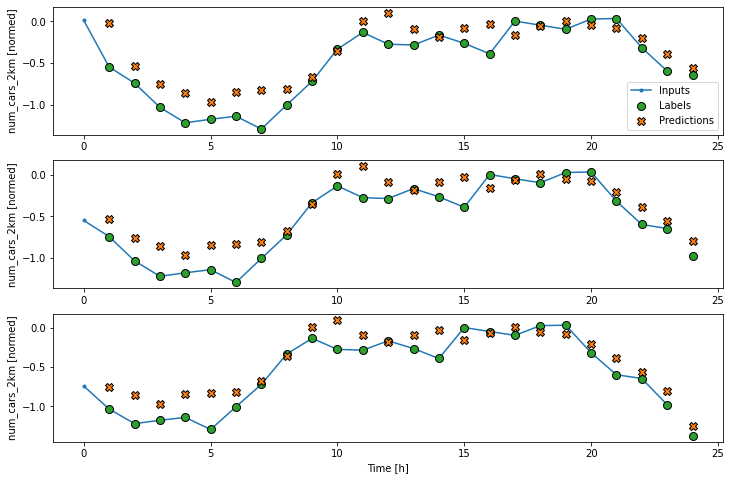

In [26]:
wide_window.plot(dense)

### Multi-step dense

In [27]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['num_cars_2km'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['num_cars_2km']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

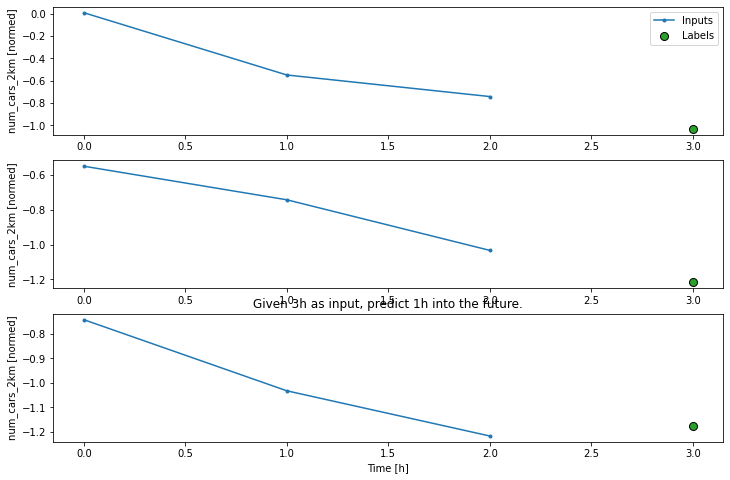

In [28]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [29]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [30]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/30
94/94 [==============================] - 1s 8ms/step - loss: 0.2530 - mean_absolute_error: 0.4015 - val_loss: 0.2218 - val_mean_absolute_error: 0.3844
Epoch 2/30
94/94 [==============================] - 1s 7ms/step - loss: 0.1437 - mean_absolute_error: 0.2973 - val_loss: 0.1892 - val_mean_absolute_error: 0.3449
Epoch 3/30
94/94 [==============================] - 1s 7ms/step - loss: 0.1325 - mean_absolute_error: 0.2851 - val_loss: 0.1889 - val_mean_absolute_error: 0.3471
Epoch 4/30
94/94 [==============================] - 1s 7ms/step - loss: 0.1054 - mean_absolute_error: 0.2523 - val_loss: 0.1846 - val_mean_absolute_error: 0.3399
Epoch 5/30
94/94 [==============================] - 1s 7ms/step - loss: 0.1078 - mean_absolute_error: 0.2560 - val_loss: 0.1391 - val_mean_absolute_error: 0.2857
Epoch 6/30
94/94 [==============================] - 1s 7ms/step - loss: 0.0985 - mean_absolute_error: 0.2415 - val_loss: 0.1554 - val_mean_absolute_error: 0.3065
Epoch 7/30
94/94 [==========

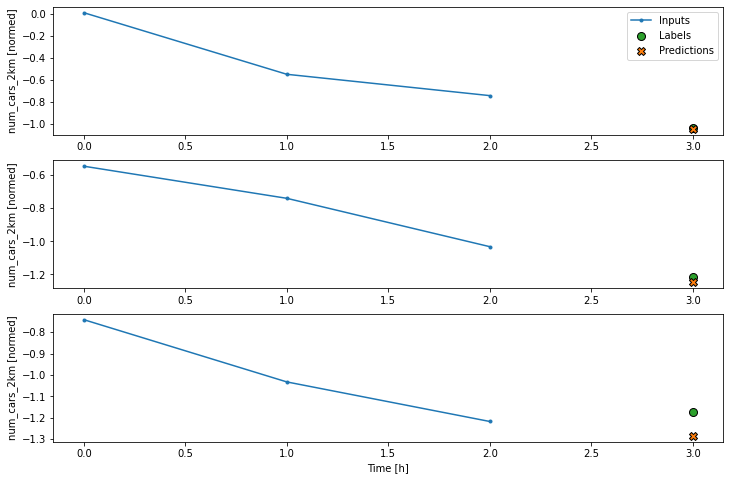

In [31]:
conv_window.plot(multi_step_dense)

### CNN

In [32]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(1,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [33]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=1)

Epoch 1/30
94/94 [==============================] - 1s 11ms/step - loss: 0.3863 - mean_absolute_error: 0.4937 - val_loss: 0.1714 - val_mean_absolute_error: 0.3311
Epoch 2/30
94/94 [==============================] - 1s 9ms/step - loss: 0.1736 - mean_absolute_error: 0.3310 - val_loss: 0.1692 - val_mean_absolute_error: 0.3220
Epoch 3/30
94/94 [==============================] - 1s 9ms/step - loss: 0.1420 - mean_absolute_error: 0.2925 - val_loss: 0.1467 - val_mean_absolute_error: 0.3016
Epoch 4/30
94/94 [==============================] - 1s 8ms/step - loss: 0.1064 - mean_absolute_error: 0.2539 - val_loss: 0.1622 - val_mean_absolute_error: 0.3151
Epoch 5/30
94/94 [==============================] - 1s 9ms/step - loss: 0.0886 - mean_absolute_error: 0.2297 - val_loss: 0.1845 - val_mean_absolute_error: 0.3426
Epoch 6/30
94/94 [==============================] - 1s 8ms/step - loss: 0.0807 - mean_absolute_error: 0.2186 - val_loss: 0.1356 - val_mean_absolute_error: 0.2890
Epoch 7/30
94/94 [=========

In [34]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['num_cars_2km'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['num_cars_2km']

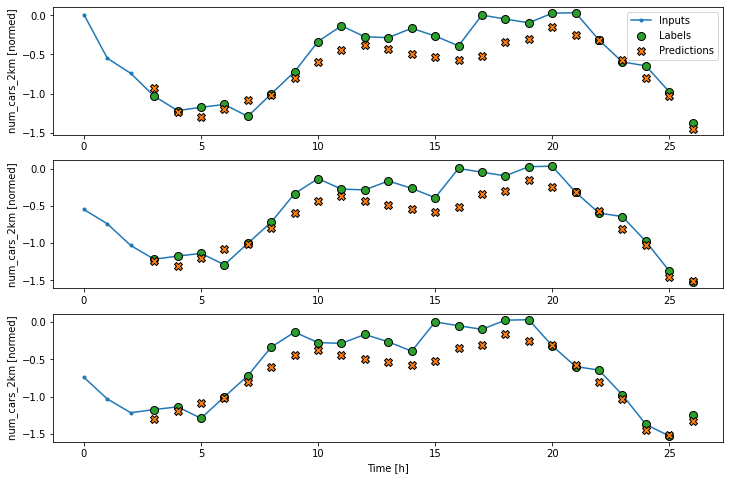

In [35]:
wide_conv_window.plot(conv_model)

### RNN

In [36]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [37]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=1)

Epoch 1/30
94/94 [==============================] - 3s 36ms/step - loss: 0.8131 - mean_absolute_error: 0.7284 - val_loss: 1.1555 - val_mean_absolute_error: 0.8668
Epoch 2/30
94/94 [==============================] - 2s 20ms/step - loss: 0.6519 - mean_absolute_error: 0.6513 - val_loss: 0.5513 - val_mean_absolute_error: 0.5895
Epoch 3/30
94/94 [==============================] - 2s 19ms/step - loss: 0.3968 - mean_absolute_error: 0.5001 - val_loss: 0.3836 - val_mean_absolute_error: 0.4903
Epoch 4/30
94/94 [==============================] - 2s 19ms/step - loss: 0.2389 - mean_absolute_error: 0.3797 - val_loss: 0.2150 - val_mean_absolute_error: 0.3614
Epoch 5/30
94/94 [==============================] - 2s 20ms/step - loss: 0.1738 - mean_absolute_error: 0.3181 - val_loss: 0.2303 - val_mean_absolute_error: 0.3795
Epoch 6/30
94/94 [==============================] - 2s 19ms/step - loss: 0.1442 - mean_absolute_error: 0.2865 - val_loss: 0.1545 - val_mean_absolute_error: 0.3046
Epoch 7/30
94/94 [====

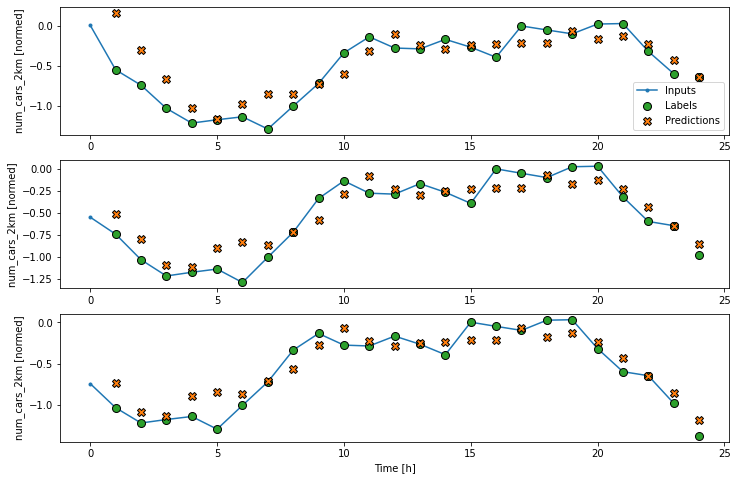

In [38]:
wide_window.plot(lstm_model)

### Comparison

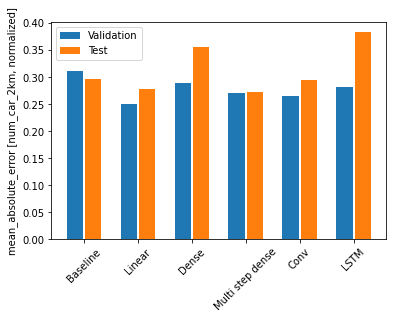

In [39]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [num_car_2km, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [40]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2960
Linear      : 0.2784
Dense       : 0.3560
Multi step dense: 0.2725
Conv        : 0.2946
LSTM        : 0.3827


## Multi-output models

In [41]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['num_cars_2km', 'num_cars_5km', 'num_cars_10km', 'Avg_speed_2km', 'Avg_speed_5km', 'Avg_speed_10km', 'aqi'])

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 51)
Labels shape (batch, time, features): (64, 24, 7)


### Baseline

In [42]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [43]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

ValueError: ignored

### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=1)

### RNN

In [ ]:
# wide_window = WindowGenerator(
#     input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=51)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=1)

print()

### ResNet

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        units = 7,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

### Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

# Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

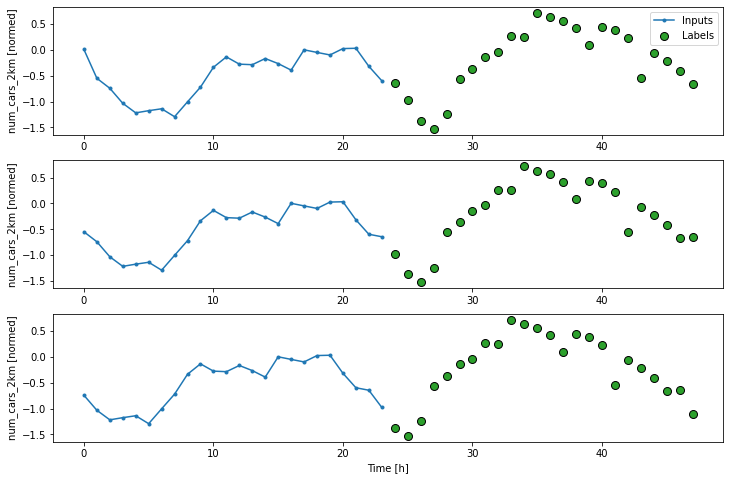

In [44]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baselines

27/27 [==============================] - 0s 5ms/step - loss: 1.0936 - mean_absolute_error: 0.6790


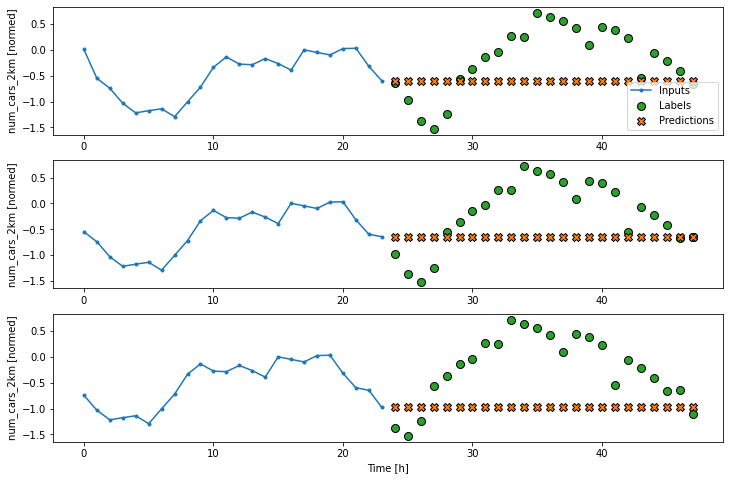

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

27/27 [==============================] - 0s 6ms/step - loss: 0.6098 - mean_absolute_error: 0.4590


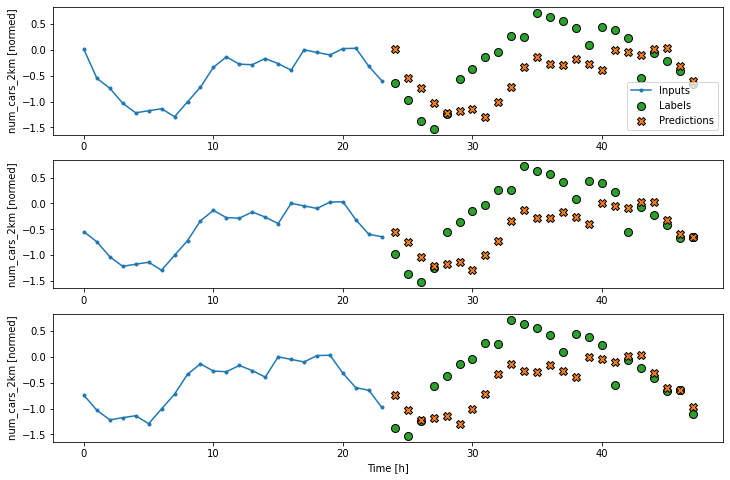

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models

Epoch 1/30
94/94 [==============================] - 1s 9ms/step - loss: 0.7361 - mean_absolute_error: 0.6729 - val_loss: 1.0870 - val_mean_absolute_error: 0.7760
Epoch 2/30
94/94 [==============================] - 1s 8ms/step - loss: 0.5435 - mean_absolute_error: 0.5603 - val_loss: 0.9328 - val_mean_absolute_error: 0.7134
Epoch 3/30
94/94 [==============================] - 1s 8ms/step - loss: 0.4841 - mean_absolute_error: 0.5233 - val_loss: 0.8669 - val_mean_absolute_error: 0.6872
Epoch 4/30
94/94 [==============================] - 1s 8ms/step - loss: 0.4527 - mean_absolute_error: 0.5025 - val_loss: 0.8265 - val_mean_absolute_error: 0.6698
Epoch 5/30
94/94 [==============================] - 1s 8ms/step - loss: 0.4322 - mean_absolute_error: 0.4884 - val_loss: 0.7964 - val_mean_absolute_error: 0.6557
Epoch 6/30
94/94 [==============================] - 1s 8ms/step - loss: 0.4174 - mean_absolute_error: 0.4778 - val_loss: 0.7724 - val_mean_absolute_error: 0.6438
Epoch 7/30
94/94 [==========

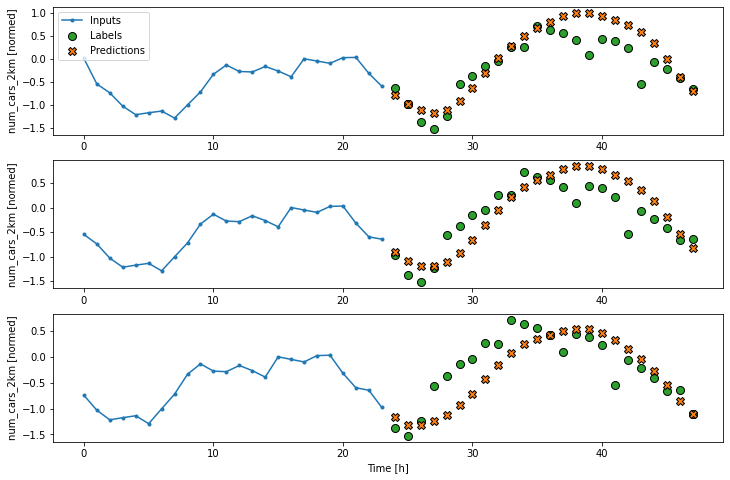

In [46]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

Epoch 1/30
94/94 [==============================] - 1s 12ms/step - loss: 0.8178 - mean_absolute_error: 0.7068 - val_loss: 1.6868 - val_mean_absolute_error: 0.9952
Epoch 2/30
94/94 [==============================] - 1s 10ms/step - loss: 0.7429 - mean_absolute_error: 0.6644 - val_loss: 1.6447 - val_mean_absolute_error: 0.9855
Epoch 3/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6802 - mean_absolute_error: 0.6307 - val_loss: 1.6753 - val_mean_absolute_error: 0.9918
Epoch 4/30
94/94 [==============================] - 1s 11ms/step - loss: 0.6451 - mean_absolute_error: 0.6103 - val_loss: 1.5517 - val_mean_absolute_error: 0.9519
Epoch 5/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6011 - mean_absolute_error: 0.5855 - val_loss: 1.4709 - val_mean_absolute_error: 0.9205
Epoch 6/30
94/94 [==============================] - 1s 11ms/step - loss: 0.5468 - mean_absolute_error: 0.5555 - val_loss: 1.2222 - val_mean_absolute_error: 0.8349
Epoch 7/30
94/94 [====

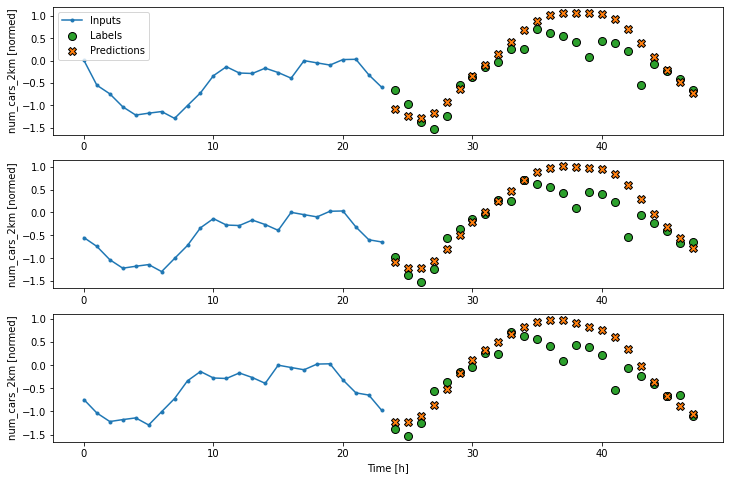

In [47]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

Epoch 1/30
94/94 [==============================] - 1s 10ms/step - loss: 0.6884 - mean_absolute_error: 0.6378 - val_loss: 1.4570 - val_mean_absolute_error: 0.9382
Epoch 2/30
94/94 [==============================] - 1s 8ms/step - loss: 0.5386 - mean_absolute_error: 0.5542 - val_loss: 0.9595 - val_mean_absolute_error: 0.7404
Epoch 3/30
94/94 [==============================] - 1s 9ms/step - loss: 0.4352 - mean_absolute_error: 0.4889 - val_loss: 0.8026 - val_mean_absolute_error: 0.6694
Epoch 4/30
94/94 [==============================] - 1s 8ms/step - loss: 0.3779 - mean_absolute_error: 0.4500 - val_loss: 0.7422 - val_mean_absolute_error: 0.6364
Epoch 5/30
94/94 [==============================] - 1s 9ms/step - loss: 0.3454 - mean_absolute_error: 0.4254 - val_loss: 0.6835 - val_mean_absolute_error: 0.6056
Epoch 6/30
94/94 [==============================] - 1s 9ms/step - loss: 0.3242 - mean_absolute_error: 0.4088 - val_loss: 0.6563 - val_mean_absolute_error: 0.5907
Epoch 7/30
94/94 [=========

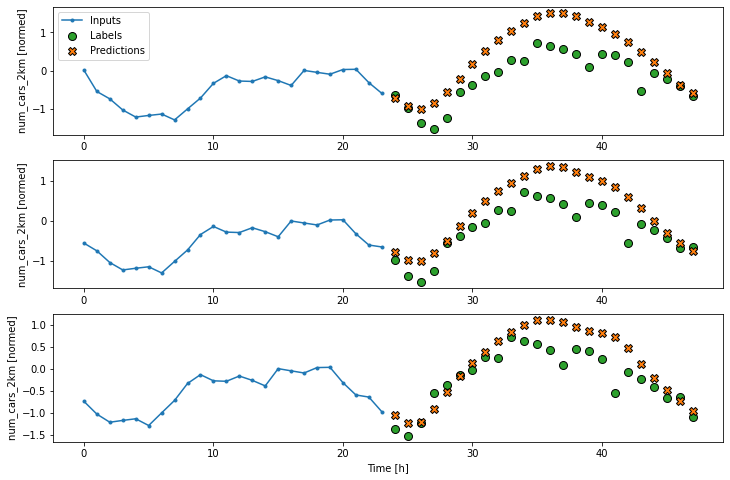

In [48]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)


multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN

Epoch 1/30
94/94 [==============================] - 3s 28ms/step - loss: 0.8750 - mean_absolute_error: 0.7374 - val_loss: 1.5405 - val_mean_absolute_error: 0.9690
Epoch 2/30
94/94 [==============================] - 1s 15ms/step - loss: 0.7733 - mean_absolute_error: 0.6843 - val_loss: 1.6397 - val_mean_absolute_error: 0.9849
Epoch 3/30
94/94 [==============================] - 1s 15ms/step - loss: 0.6871 - mean_absolute_error: 0.6355 - val_loss: 1.4981 - val_mean_absolute_error: 0.9268
Epoch 4/30
94/94 [==============================] - 1s 15ms/step - loss: 0.6005 - mean_absolute_error: 0.5883 - val_loss: 1.3485 - val_mean_absolute_error: 0.8622
Epoch 5/30
94/94 [==============================] - 1s 15ms/step - loss: 0.5521 - mean_absolute_error: 0.5608 - val_loss: 1.4091 - val_mean_absolute_error: 0.8905
Epoch 6/30
94/94 [==============================] - 1s 15ms/step - loss: 0.5270 - mean_absolute_error: 0.5434 - val_loss: 1.1650 - val_mean_absolute_error: 0.8052
Epoch 7/30
94/94 [====

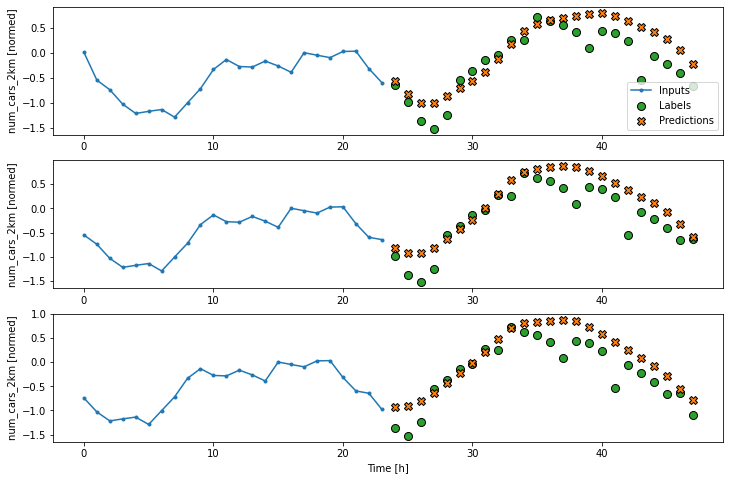

In [49]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Advanced: Autoregressive model

### RNN

In [50]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [51]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [52]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [53]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([64, 51])

In [54]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [55]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (64, 24, 51)


Epoch 1/30
94/94 [==============================] - 6s 64ms/step - loss: 0.9251 - mean_absolute_error: 0.7647 - val_loss: 1.5373 - val_mean_absolute_error: 0.9604
Epoch 2/30
94/94 [==============================] - 5s 57ms/step - loss: 0.8307 - mean_absolute_error: 0.7146 - val_loss: 1.5452 - val_mean_absolute_error: 0.9602
Epoch 3/30
94/94 [==============================] - 6s 59ms/step - loss: 0.8017 - mean_absolute_error: 0.7022 - val_loss: 1.3771 - val_mean_absolute_error: 0.9089
Epoch 4/30
94/94 [==============================] - 6s 60ms/step - loss: 0.7661 - mean_absolute_error: 0.6819 - val_loss: 1.2958 - val_mean_absolute_error: 0.8746
Epoch 5/30
94/94 [==============================] - 6s 59ms/step - loss: 0.7022 - mean_absolute_error: 0.6497 - val_loss: 1.2631 - val_mean_absolute_error: 0.8603
Epoch 6/30
94/94 [==============================] - 5s 57ms/step - loss: 0.6351 - mean_absolute_error: 0.6115 - val_loss: 1.1978 - val_mean_absolute_error: 0.8263
Epoch 7/30
94/94 [====

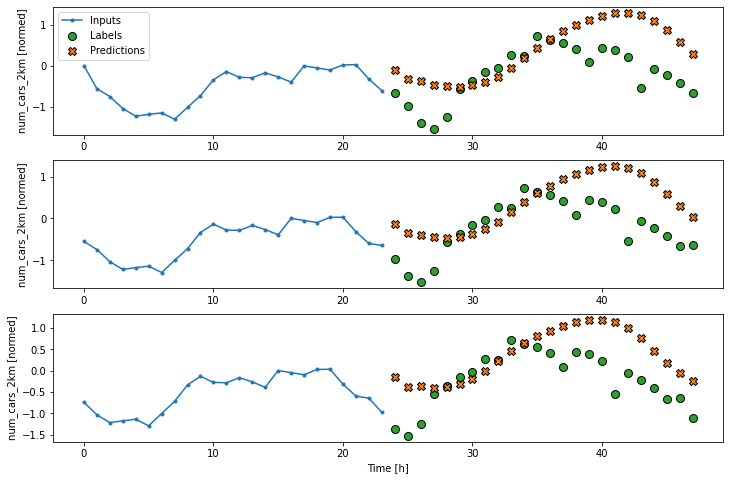

In [56]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance

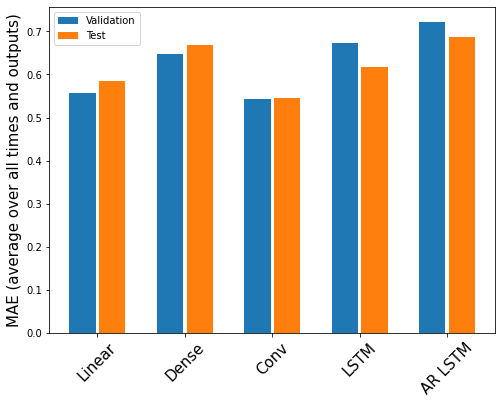

In [70]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8,6))
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45, fontsize = 15)
plt.ylabel(f'MAE (average over all times and outputs)', fontsize = 15)
_ = plt.legend()

In [58]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Linear  : 0.5839
Dense   : 0.6674
Conv    : 0.5451
LSTM    : 0.6182
AR LSTM : 0.6872


Reference: https://colab.research.google.com/drive/1YROgTvuHCRANL4s7jHH4lcZlVFlkOLb4?authuser=1#scrollTo=W4KbxfzqkXPW